In [1]:
import os
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Select subset of complete genomes

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


In [4]:
complete_genomes_df = assembly_df[assembly_df['assembly_level'] == 'Complete Genome'].copy()
print(f'Number of complete genomes: {len(complete_genomes_df):,}')

n_phyla = len(complete_genomes_df['phylum'].unique())
print('Number of phylum with complete genomes:', n_phyla)

Number of complete genomes: 2,592
Number of phylum with complete genomes: 54


## Distribution difference between assemblies

In [5]:
dist_path = os.path.join(os.getcwd(), 'data/tri_nucleotide_dist_genome_wide_with_overlap.csv')
all_dist_df = pd.read_csv(dist_path, index_col='assembly_accession')
all_dist_df.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCA_000010525.1,0.004115,0.007124,0.011835,0.004847,0.007094,0.015712,0.016362,0.003881,0.010272,0.019491,...,0.024917,0.010272,0.012014,0.020576,0.019954,0.007094,0.001352,0.013885,0.008569,0.004115
GCA_000218545.1,0.000252,0.005763,0.004077,0.000274,0.005262,0.022188,0.030573,0.003879,0.004911,0.019988,...,0.035758,0.004911,0.008300,0.020709,0.015651,0.005262,0.000147,0.006289,0.003678,0.000252
GCA_000020965.1,0.048815,0.013374,0.028937,0.032000,0.011956,0.009895,0.002538,0.014662,0.027912,0.010500,...,0.003200,0.027912,0.015535,0.009474,0.012546,0.011956,0.031846,0.023655,0.018809,0.048815
GCA_000012885.1,0.021573,0.015209,0.014557,0.012728,0.011622,0.017907,0.013091,0.007819,0.011598,0.015412,...,0.020690,0.011598,0.014604,0.020497,0.018479,0.011622,0.007861,0.017810,0.016824,0.021573
GCA_001735525.1,0.025601,0.018183,0.018755,0.020473,0.014695,0.015270,0.010687,0.014937,0.013837,0.019272,...,0.013112,0.013837,0.020200,0.018597,0.017784,0.014695,0.021364,0.013529,0.022517,0.025601


In [6]:
dist_df = all_dist_df.loc[complete_genomes_df.index].copy()

In [7]:
triplets = np.array(dist_df.columns.tolist())

In [8]:
e_coli_assembly = assembly_df[assembly_df['organism_name'].str.contains('Escherichia coli')].index[0]

k_aerogenes_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Klebsiella aerogenes')
].index[0]

d_thermophilum_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Dictyoglomus thermophilum')
].index[0]

In [9]:
all_dist_df.loc[[e_coli_assembly, k_aerogenes_assembly, d_thermophilum_assembly]]

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCA_000800765.1,0.023540,0.017802,0.013704,0.017901,0.012598,0.016073,0.015793,0.010750,0.012075,0.017388,...,0.015394,0.012075,0.018049,0.020620,0.018503,0.012598,0.014827,0.018024,0.016556,0.023540
GCA_000215745.1,0.019476,0.015229,0.012799,0.014629,0.009838,0.016255,0.015526,0.008665,0.010772,0.020615,...,0.018413,0.010772,0.016187,0.019312,0.018253,0.009838,0.012562,0.016546,0.013548,0.019476
GCA_000020965.1,0.048815,0.013374,0.028937,0.032000,0.011956,0.009895,0.002538,0.014662,0.027912,0.010500,...,0.003200,0.027912,0.015535,0.009474,0.012546,0.011956,0.031846,0.023655,0.018809,0.048815


In [10]:
e_coli_dist = all_dist_df.loc[e_coli_assembly].values
k_aerogenes_dist = all_dist_df.loc[k_aerogenes_assembly].values
d_thermophilum_dist = all_dist_df.loc[d_thermophilum_assembly].values

In [11]:
def plot_percentage_difference(ref_dist, candidate_dist, percent=True, reverse_complement=True):
    if reverse_complement:
        height = 10
    else:
        height = 20
    
    _, ax = plt.subplots(1, 1, figsize=(15, height))
    
    to_reverse_comp = {
        t: str(Seq(t).reverse_complement())
        for t in triplets
    }

    if percent:
        diff = 100 * (ref_dist - candidate_dist) / ref_dist
    else:
        diff = ref_dist - candidate_dist
        
    diff_abs = np.abs(diff)
    ix = np.argsort(diff_abs)

    triplets_sorted = triplets[ix]
    diff_sorted = diff[ix]
    
    if reverse_complement:
        triplet_labels = [
            f'{t} / {to_reverse_comp[t]}' 
            for i, t in enumerate(triplets_sorted)
            if i % 2 == 0
        ]
        diff_data = [
            d
            for i, d in enumerate(diff_sorted)
            if i % 2 == 0
        ]
    else:
        triplet_labels = triplets_sorted
        diff_data = diff_sorted

    ax.barh(triplet_labels, diff_data);

    x_min, x_max = ax.get_xlim()
    x_max_abs = np.amax([np.abs(x_min), np.abs(x_max)])
    ax.set_xlim(-x_max_abs, x_max_abs)
    
    if percent:
        ax.set_xlabel('Percentage difference');
    else:
        ax.set_xlabel('Difference');
    
    return ax

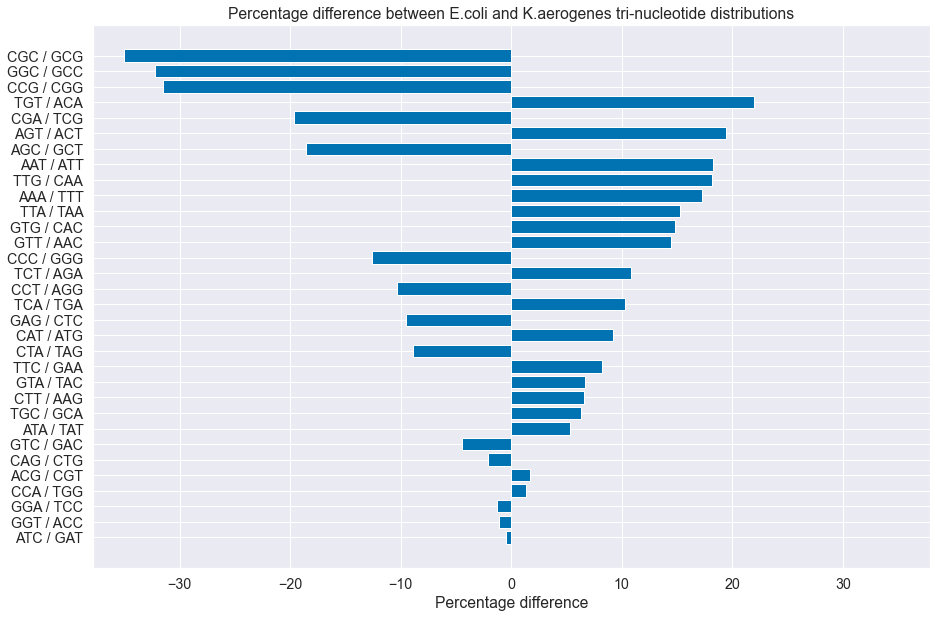

In [12]:
ax = plot_percentage_difference(e_coli_dist, k_aerogenes_dist)
ax.set_title('Percentage difference between E.coli and K.aerogenes tri-nucleotide distributions');

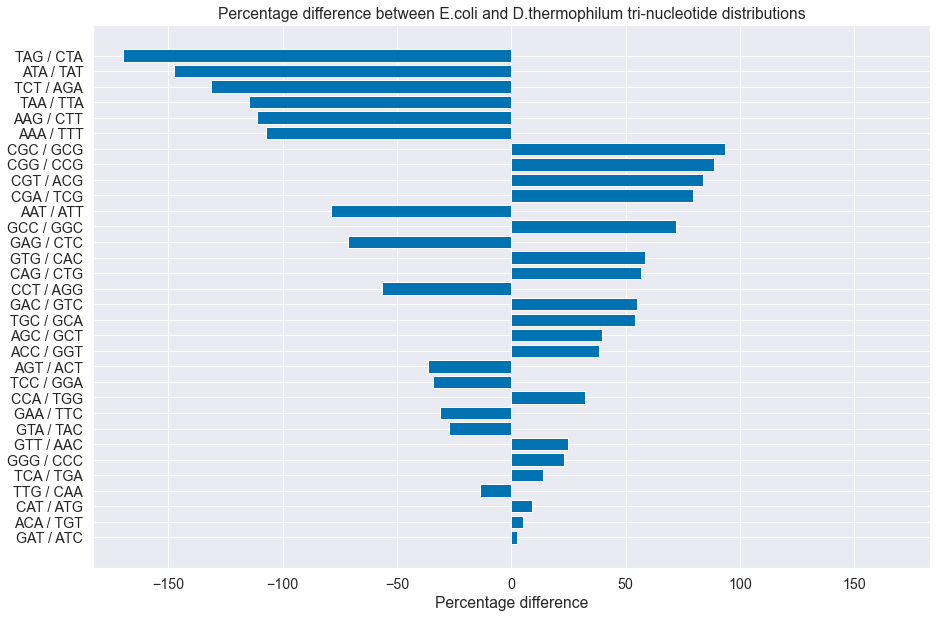

In [13]:
ax = plot_percentage_difference(e_coli_dist, d_thermophilum_dist)
ax.set_title('Percentage difference between E.coli and D.thermophilum tri-nucleotide distributions');

## Within genome

In [14]:
def load_gene_distributions(assembly):
    dist_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_tri_nucleotide_dist_without_rc_with_overlap.csv.gz',
    )
    df = pd.read_csv(dist_path, index_col='protein_id')
    return df

In [15]:
e_coli_gene_dist_df = load_gene_distributions(e_coli_assembly)
e_coli_gene_dist_df.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
protein_id,,,,,,,,,,,,,,,,,,,,,
AIZ54182.1,0.015625,0.031250,0.000000,0.000000,0.015625,0.109375,0.031250,0.000000,0.000000,0.015625,...,0.000000,0.000000,0.031250,0.015625,0.000000,0.000000,0.046875,0.000000,0.000000,0.000000
AIZ50783.1,0.023568,0.015035,0.015441,0.017473,0.006095,0.014628,0.013409,0.011784,0.007720,0.011377,...,0.013409,0.018692,0.021942,0.027631,0.027631,0.012597,0.013409,0.016254,0.019504,0.014628
AIZ51761.1,0.017186,0.012889,0.016112,0.008593,0.009667,0.011815,0.012889,0.008593,0.009667,0.018260,...,0.019334,0.007519,0.022556,0.025779,0.022556,0.011815,0.010741,0.013963,0.019334,0.018260
AIZ52710.1,0.027237,0.018677,0.017899,0.015564,0.008560,0.012451,0.017121,0.013230,0.013230,0.018677,...,0.013230,0.011673,0.028794,0.027237,0.021012,0.012451,0.010895,0.012451,0.021790,0.021790
AIZ53685.1,0.030508,0.010169,0.010169,0.020339,0.020339,0.020339,0.013559,0.013559,0.010169,0.006780,...,0.020339,0.006780,0.013559,0.006780,0.040678,0.000000,0.016949,0.006780,0.000000,0.003390


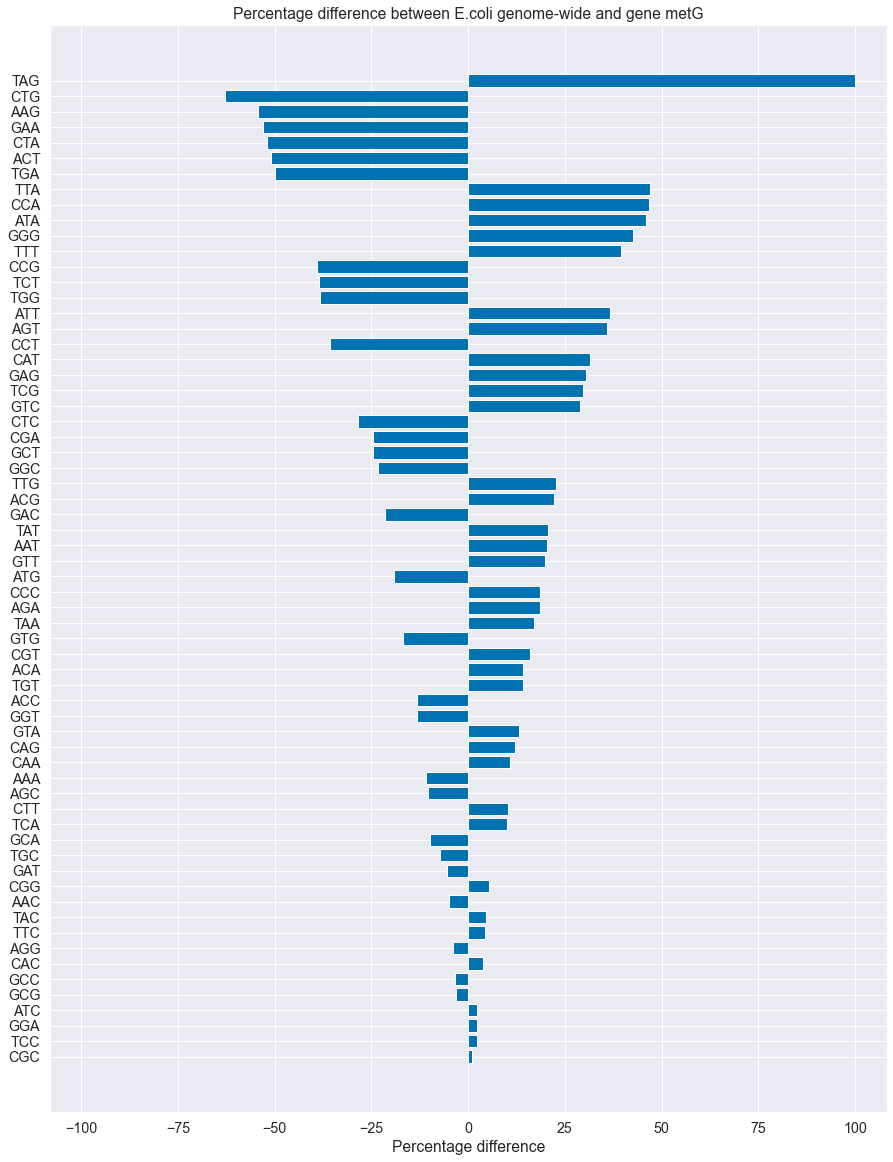

In [16]:
ax = plot_percentage_difference(e_coli_dist, e_coli_gene_dist_df.loc['AIZ51924.1'].values, reverse_complement=False)
ax.set_title('Percentage difference between E.coli genome-wide and gene metG');

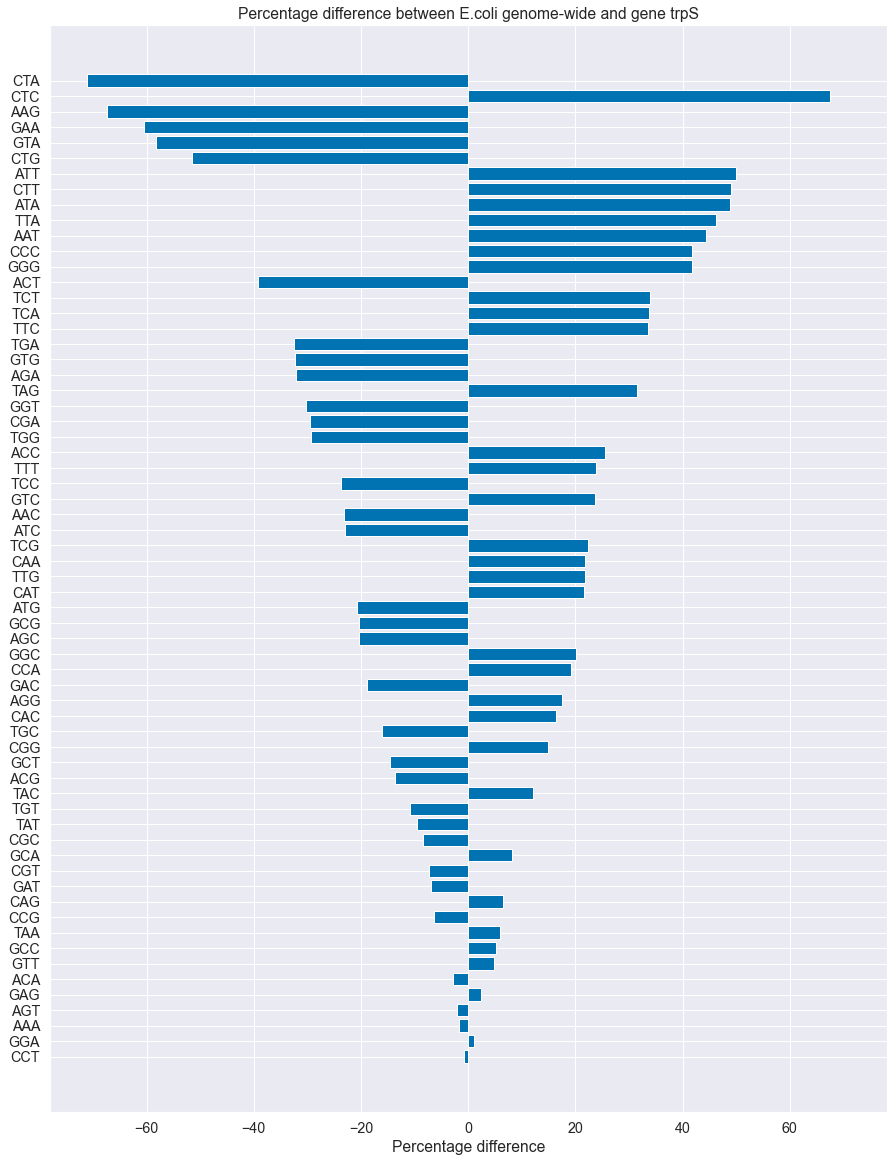

In [17]:
ax = plot_percentage_difference(e_coli_dist, e_coli_gene_dist_df.loc['AIZ53175.1'].values, reverse_complement=False)
ax.set_title('Percentage difference between E.coli genome-wide and gene trpS');